#### Filtering GEDI
##### - Vegetation mask specific year
##### - Selecting specific year
##### - Removing outliers
##### - Quality flags + Night + Power

In [1]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd

import rasterio

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#################################
# GEDI footprints path
#################################
# gedi_path = '/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/gedi/test/l4a_t90km_t99.gpkg'
gedi_path = '/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/gedi/test/l4a_t90km_t89.gpkg'

base_name = os.path.splitext(os.path.basename(gedi_path))[0]
#################################
# Veg mask year i
#################################
target_year = 2022
# target_year = os.path.basename(os.path.dirname(img_path))
img_path = f'/projects/my-private-bucket/HLS-1DCNN-AGB/data/tif/VegetationMask/AtlanticForest/{target_year}/vegmask_{target_year}.vrt'

#################################
# Output path
#################################
output_gedi_clean_path = f'/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/gedi/test/{base_name}_veg{target_year}_outrm.gpkg'

In [3]:
## Read file
l4a_gdf_all = gpd.read_file(gedi_path)

In [4]:
len(l4a_gdf_all)

444231

### Filter target year

In [5]:
l4a_gdf = l4a_gdf_all[l4a_gdf_all['year'] == target_year]

In [6]:
len(l4a_gdf)

146966

### Select footprints - power beams, min sensitivity and night shots

In [7]:
## Select footprints - power beams, min sensitivity and night shots
### Power beams
power_beams = [5, 6, 8, 11]
l4a_gdf_all['beam'] = pd.to_numeric(l4a_gdf_all['beam'], errors='coerce')

# Filter solar elevation lower than 0
# Sensitivity threshold
min_sensitivity = 0.98

l4a_gdf = l4a_gdf.copy()[(l4a_gdf['beam'].isin(power_beams)) &
                           (l4a_gdf['solar_elevation'] < 0) &
                           (l4a_gdf['sensitivity'] > min_sensitivity)
                          ]

In [1]:
len(l4a_gdf)

NameError: name 'l4a_gdf' is not defined

### Vegetation Mask

In [9]:
# gdf.crs

In [10]:
%%time
# Extract vegetation mask raster values to gedi points
with rasterio.open(img_path) as src:
    # Extract values at point coordinates (x, y)
    coords = [(x,y) for x, y in zip(l4a_gdf.geometry.x, l4a_gdf.geometry.y)]
    l4a_gdf[f"vegmask_{target_year}"] = [val[0] for val in src.sample(coords)]




CPU times: user 3.72 s, sys: 23.8 ms, total: 3.75 s
Wall time: 4.9 s


In [11]:
 l4a_gdf[f"vegmask_{target_year}"].unique()

array([0, 3], dtype=uint8)

In [12]:
# Filter out NoData values
nodata_value = 0
l4a_gdf_filtered = l4a_gdf[l4a_gdf[f"vegmask_{target_year}"] != nodata_value]

In [13]:
len(l4a_gdf)

35059

### Remove outliers

In [14]:
def remove_outliers(df, columns):
    for col in columns:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

In [15]:
l4a_gdf_filtered_clean = remove_outliers(l4a_gdf_filtered, ['agbd'])

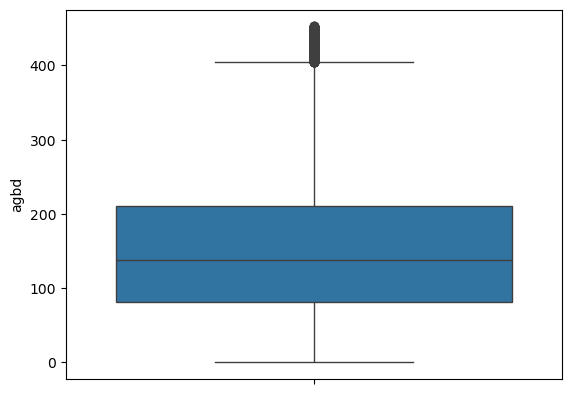

In [16]:
import seaborn as sns
sns.boxplot(y = 'agbd', data = l4a_gdf_filtered_clean)
plt.show()

In [17]:
print(f'Original: {len(l4a_gdf_all)}')
print(f'Filtered: {len(l4a_gdf_filtered_clean)}')
print(f'% left: {len(l4a_gdf_filtered_clean) / len(l4a_gdf_all) *100:.1f}')


Original: 444231
Filtered: 21507
% left: 4.8


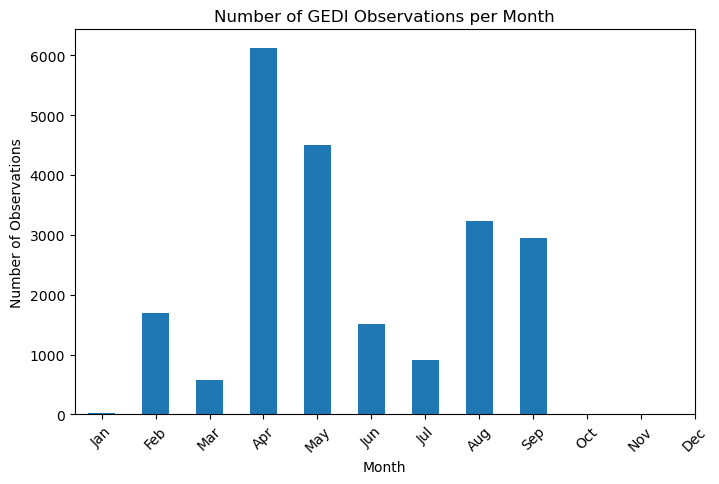

In [18]:
# Count observations per month (aggregated across all years)
month_counts = l4a_gdf_filtered_clean['month'].value_counts().sort_index()

# Plot number of observations per month
plt.figure(figsize=(8,5))
month_counts.plot(kind='bar')
plt.title("Number of GEDI Observations per Month")
plt.xlabel("Month")
plt.ylabel("Number of Observations")
plt.xticks(range(0,12), 
           ['Jan','Feb','Mar','Apr','May','Jun',
            'Jul','Aug','Sep','Oct','Nov','Dec'],
           rotation=45)
plt.show()

### Export output

In [19]:
l4a_gdf_filtered_clean.to_file(output_gedi_clean_path)